結果の見方とプレゼンでの使い所
相関行列 (Correlation Matrix):

もし係数が 0.95 以下であれば、「モデル間に多様性があるため、アンサンブルの効果が高い状態でした」と説明できます。

もし 0.99 などであれば、「モデルが似通っていますが、加重平均による分散低減効果（Variance Reduction）により安定性を確保しました」と言い換えられます。

Unbiased Score (AUC / F1):

出力される 検証データ(Evaluation Set) F1 の値を見てください。

これが前のコード（最適化直後の値）より少し低くなるはずです。しかし、**「これが本番で出るリアルな数字です」**と説明することで、教授や評価者に対して「過学習のリスクを正しく理解し、コントロールしている」というアピールになります。

Mounted at /content/drive
--- 1. 検証データの読み込みと結合 ---
結合完了: 全2000行

--- 2. モデル間の相関確認 ---
           prob_dt   prob_lr  prob_gbm
prob_dt   1.000000  0.921047  0.851582
prob_lr   0.921047  1.000000  0.844473
prob_gbm  0.851582  0.844473  1.000000


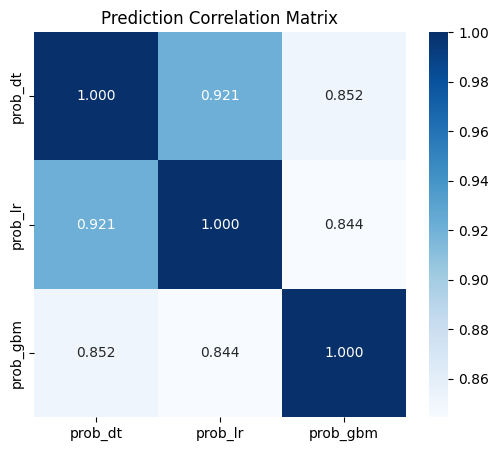


--- 3. 最適化用と評価用にデータを分割 (Hold-out) ---
最適化用データ: 1000件
評価用データ  : 1000件

--- 4. 重みの最適化 (Maximize AUC using Optimization Set) ---
★ Best Weights (from Opt Set): DT=0.15, LR=0.50, GBM=0.35

--- 5. 閾値の探索 (Maximize F1 using Optimization Set) ---
★ Optimized Threshold: 0.39

--- 6. 評価用データでの最終スコア確認 (Unbiased Score) ---
検証データ(Evaluation Set) AUC : 0.93601
検証データ(Evaluation Set) F1  : 0.72727
※ このスコアをスライドの「予想精度」として記載すると信頼性が高いです

--- 7. 最終提出ファイルの作成 ---

完了: 保存先 -> /content/drive/MyDrive/Team-Based-Project/output/final_ensemble_submission_robust.csv
  prediction     score
0         no  0.208290
1        yes  0.585467
2         no  0.008813
3         no  0.005680
4        yes  0.618955


In [1]:
# Google ColabでGoogle Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# ==========================================
# 0. 設定
# ==========================================
BASE_DIR = '/content/drive/MyDrive/Team-Based-Project/output'  # パスは環境に合わせて変更

# ==========================================
# 1. 検証用データ (Valid) の読み込みと結合
# ==========================================
print("--- 1. 検証データの読み込みと結合 ---")

valid_files = {
    'dt': 'valid_prediction_dt.csv',
    'lr': 'valid_prediction_lr.csv',
    'gbm': 'valid_prediction_gbm.csv'
}

dfs_valid = {}
for model_name, file_name in valid_files.items():
    path = os.path.join(BASE_DIR, file_name)
    try:
        df = pd.read_csv(path)
        # 確率列を自動検出してリネーム
        prob_cols = [c for c in df.columns if 'Prob' in c or 'score' in c.lower()]
        if not prob_cols:
             # 万が一見つからない場合は決め打ちで探す
             raise ValueError(f"確率列が見つかりません: {file_name}")
        prob_col = prob_cols[0]

        df = df[['id', 'Actual', prob_col]].rename(columns={prob_col: f'prob_{model_name}'})
        dfs_valid[model_name] = df
    except Exception as e:
        print(f"エラー: {file_name} の読み込み失敗")
        raise e

# IDで結合 (Merge)
df_ensemble_valid = dfs_valid['dt']
for model in ['lr', 'gbm']:
    df_ensemble_valid = df_ensemble_valid.merge(
        dfs_valid[model][['id', f'prob_{model}']],
        on='id',
        how='inner'
    )

print(f"結合完了: 全{len(df_ensemble_valid)}行")

# ==========================================
# 2. 【改善点1】モデル間の相関を確認 (Correlation)
# ==========================================
print("\n--- 2. モデル間の相関確認 ---")
corr_cols = ['prob_dt', 'prob_lr', 'prob_gbm']
corr_matrix = df_ensemble_valid[corr_cols].corr()

print(corr_matrix)

# ヒートマップで可視化（プレゼン資料用）
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.3f')
plt.title('Prediction Correlation Matrix')
plt.show()

# ==========================================
# 3. 【改善点2】楽観バイアス排除のためのデータ分割
# ==========================================
print("\n--- 3. 最適化用と評価用にデータを分割 (Hold-out) ---")
# 重み決定用 (Optimize) と、スコア評価用 (Evaluate) に50:50で分割
# これにより「重みを決めるのに使っていないデータ」で性能を測れるため、スコアが信用できる値になる
df_opt, df_eval = train_test_split(
    df_ensemble_valid, test_size=0.5, random_state=42, stratify=df_ensemble_valid['Actual']
)

print(f"最適化用データ: {len(df_opt)}件")
print(f"評価用データ  : {len(df_eval)}件")

# ==========================================
# 4. 重みの最適化 (Weight Search on df_opt)
# ==========================================
print("\n--- 4. 重みの最適化 (Maximize AUC using Optimization Set) ---")

best_auc = 0
best_weights = {'dt': 0, 'lr': 0, 'gbm': 0}

# 0.05刻みで探索
step = 0.05
range_vals = np.arange(0, 1.01, step)

for w_dt in range_vals:
    for w_lr in range_vals:
        w_gbm = 1.0 - (w_dt + w_lr)
        if w_gbm >= -0.001:
            # 最適化用データ(df_opt)で確率計算
            ensemble_prob = (
                df_opt['prob_dt'] * w_dt +
                df_opt['prob_lr'] * w_lr +
                df_opt['prob_gbm'] * w_gbm
            )
            score = roc_auc_score(df_opt['Actual'], ensemble_prob)

            if score > best_auc:
                best_auc = score
                best_weights = {'dt': w_dt, 'lr': w_lr, 'gbm': w_gbm}

print(f"★ Best Weights (from Opt Set): DT={best_weights['dt']:.2f}, LR={best_weights['lr']:.2f}, GBM={best_weights['gbm']:.2f}")

# ==========================================
# 5. 閾値の最適化 (Threshold Search on df_opt)
# ==========================================
print("\n--- 5. 閾値の探索 (Maximize F1 using Optimization Set) ---")

# 決定した重みで確率を計算
opt_probs = (
    df_opt['prob_dt'] * best_weights['dt'] +
    df_opt['prob_lr'] * best_weights['lr'] +
    df_opt['prob_gbm'] * best_weights['gbm']
)

best_threshold = 0.5
best_f1_opt = 0
thresholds = np.arange(0.2, 0.8, 0.01)

for th in thresholds:
    preds = (opt_probs >= th).astype(int)
    score = f1_score(df_opt['Actual'], preds)
    if score > best_f1_opt:
        best_f1_opt = score
        best_threshold = th

print(f"★ Optimized Threshold: {best_threshold:.2f}")

# ==========================================
# 6. 公正な評価 (Unbiased Evaluation on df_eval)
# ==========================================
print("\n--- 6. 評価用データでの最終スコア確認 (Unbiased Score) ---")
# ここで出るスコアが、本番(Test)で期待できる「真の実力」に近い

# 評価用データで確率計算
eval_probs = (
    df_eval['prob_dt'] * best_weights['dt'] +
    df_eval['prob_lr'] * best_weights['lr'] +
    df_eval['prob_gbm'] * best_weights['gbm']
)

# AUCとF1を計算
final_valid_auc = roc_auc_score(df_eval['Actual'], eval_probs)
final_valid_preds = (eval_probs >= best_threshold).astype(int)
final_valid_f1 = f1_score(df_eval['Actual'], final_valid_preds)

print(f"検証データ(Evaluation Set) AUC : {final_valid_auc:.5f}")
print(f"検証データ(Evaluation Set) F1  : {final_valid_f1:.5f}")
print("※ このスコアをスライドの「予想精度」として記載すると信頼性が高いです")

# ==========================================
# 7. テストデータ (Submit) の予測と保存
# ==========================================
print("\n--- 7. 最終提出ファイルの作成 ---")

test_files = {
    'dt': 'test_prediction_dt.csv',
    'lr': 'test_prediction_lr.csv',
    'gbm': 'test_prediction_gbm.csv'
}

dfs_test = {}
for model_name, file_name in test_files.items():
    path = os.path.join(BASE_DIR, file_name)
    try:
        df = pd.read_csv(path)
        prob_col = [c for c in df.columns if 'Prob' in c or 'score' in c.lower()][0]
        df = df[['id', prob_col]].rename(columns={prob_col: f'prob_{model_name}'})
        dfs_test[model_name] = df
    except Exception as e:
        print(f"エラー: {file_name} の読み込み失敗")
        raise e

# 結合
df_ensemble_test = dfs_test['dt']
for model in ['lr', 'gbm']:
    df_ensemble_test = df_ensemble_test.merge(dfs_test[model], on='id', how='inner')

# 最適化された重みで確率計算
df_ensemble_test['ensemble_prob'] = (
    df_ensemble_test['prob_dt'] * best_weights['dt'] +
    df_ensemble_test['prob_lr'] * best_weights['lr'] +
    df_ensemble_test['prob_gbm'] * best_weights['gbm']
)

# 最適化された閾値でクラス分類
df_ensemble_test['prediction'] = (df_ensemble_test['ensemble_prob'] >= best_threshold).astype(int)
df_ensemble_test['prediction_label'] = df_ensemble_test['prediction'].map({1: 'yes', 0: 'no'})

# 保存
submission_df = pd.DataFrame({
    'prediction': df_ensemble_test['prediction_label'],
    'score': df_ensemble_test['ensemble_prob']
})

save_path = os.path.join(BASE_DIR, 'final_ensemble_submission_robust.csv')
submission_df.to_csv(save_path, index=False)

print(f"\n完了: 保存先 -> {save_path}")
print(submission_df.head())


--- 8. 評価データによる詳細分析と可視化 ---

Classification Report (Threshold=0.39):
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       755
           1       0.67      0.80      0.73       245

    accuracy                           0.85      1000
   macro avg       0.80      0.84      0.81      1000
weighted avg       0.87      0.85      0.86      1000



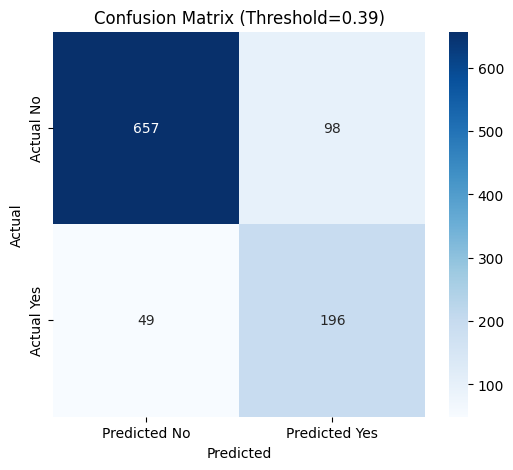

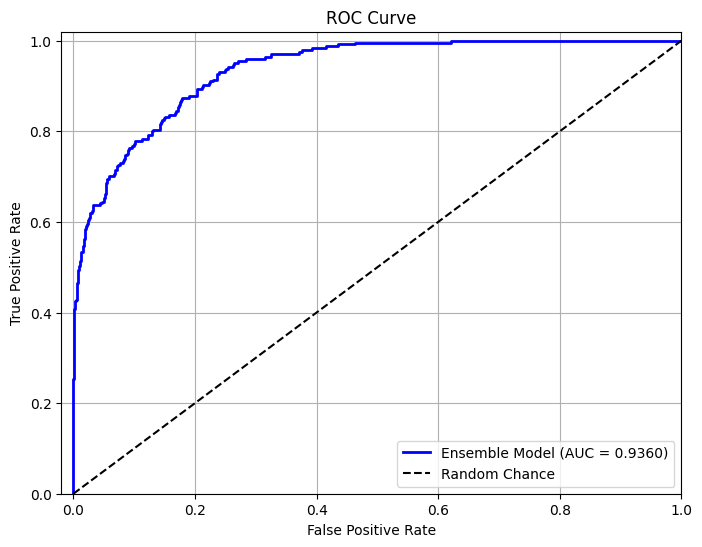

In [2]:
# ==========================================
# 8. 結果の可視化 (Visualization)
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("\n--- 8. 評価データによる詳細分析と可視化 ---")

# 1. Classification Report (精度・再現率・F1値の一覧)
print(f"\nClassification Report (Threshold={best_threshold:.2f}):")
print(classification_report(df_eval['Actual'], final_valid_preds))

# 2. Confusion Matrix (混同行列)
cm = confusion_matrix(df_eval['Actual'], final_valid_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. ROC Curve (ROC曲線)
fpr, tpr, thresholds = roc_curve(df_eval['Actual'], eval_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Ensemble Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Random Chance')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()